# MNIST XCNN with graident ascent and feature maps

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, Flatten, Dense
from keras.models import Model
import tensorflow as tf
import random

Load and preprocess the MNIST dataset. (build a binary classifier for 8 and not 8)

In [10]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Modify labels: 8s are labeled as 1, non-8s are labeled as 0
y_train_binary = np.where(y_train == 8, 1, 0)
y_test_binary = np.where(y_test == 8, 1, 0)

# Preprocess the data
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

# Split the dataset into training and validation sets
X_train, X_val, y_train_binary, y_val_binary = train_test_split(X_train, y_train_binary, test_size=0.2, random_state=42)

We will define a simple CNN ending with a 1x1x50 convolution passed to a FC layer

In [11]:
# Define the input layer
input_layer = Input(shape=(28, 28, 1))

# Convolutional layers
conv1 = Conv2D(2, (3, 3), padding='same', activation='relu')(input_layer)
conv2 = Conv2D(50, (1, 1), activation='relu')(conv1)
conv3 = Conv2D(50, (28, 28), activation='relu')(conv2)

# Flatten the output for the fully connected layer
flatten = Flatten()(conv3)

# Fully connected and output layers
output_layer = Dense(1, activation='sigmoid')(flatten)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Display the model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Load the pre-trained model or train it
try:
    model = tf.keras.models.load_model('model/xcnn.h5')
except:
    history = model.fit(X_train, y_train_binary, epochs=5, batch_size=64, validation_data=(X_val, y_val_binary))

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(X_test, y_test_binary)
    print(f'Test accuracy: {test_acc}')

    # Save the trained model
    model.save('model/xcnn.h5')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 2)         20        
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 50)        150       
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 1, 50)          1960050   
                                                                 
 flatten_1 (Flatten)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1960271 (7.48 MB)
Trainable params: 1960271 (

In [12]:
for layer in model.layers:
    print(layer.name)


input_2
conv2d_5
conv2d_6
conv2d_7
conv2d_8
conv2d_9
flatten_1
dense_1


A few helper functions

In [13]:
def get_submodel(model, layer_name):
  return tf.keras.models.Model(
      model.input,
      model.get_layer(layer_name).output
  )

In [14]:
def create_image():
  return tf.random.uniform((28,28, 1), minval = -0.5, maxval = 0.5)

#plots the image
def plot_image(image, title = 'random'):
  image = image - tf.math.reduce_min(image)
  image = image / tf.math.reduce_max(image)
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.title(title)
  plt.show()

#gradient ascent for maximising the given filter's output
def visualise_filters(model, layer_name, f_index = None, iters = 2000):
  submodel = get_submodel(model, layer_name)
  num_filters = submodel.output.shape[-1]

  if f_index is None:
    f_index = random.randint(0, num_filters - 1)

  assert num_filters > f_index, 'filter index out of bounds'

  image = create_image()
  verbose_step = int(iters / 100)

  for i in range(0, iters):
    with tf.GradientTape() as tape:
      tape.watch(image)
      out = submodel(tf.expand_dims(image, axis = 0))[:, :, :, f_index]
      loss = tf.math.reduce_mean(out)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += grads * 10

  
  if (i + 1) % verbose_step == 0:
      print(f'Iteration: {i + 1}, Loss: {loss.numpy():.4f}')

  plot_image(image, f'{layer_name}, {f_index}')

Let's perform activation mapping for a particular image (using a positive class example for starters)

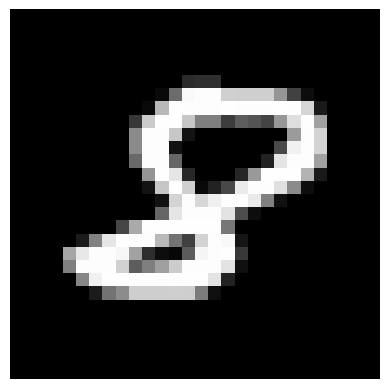

Probability that the given image is 8 : 0.7153711318969727


In [15]:
image = X_test[61]

# Plot the image
plt.imshow(image.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

# Make the model predict on the image
prediction = model.predict(image.reshape(1, 28, 28, 1), verbose = 0)
print(f'Probability that the given image is 8 : {prediction[0][0]}')


In [16]:
#getting the weights of the last layer
weights_FC = model.layers[-1].get_weights()[0]


#getting the output of the last convolutional layer
model_penultimate = get_submodel(model, 'flatten_1')

#obtain the output of the last convolutional layer
activations_penultimate = model_penultimate.predict(image.reshape(1, 28, 28, 1), verbose = 0)

print(activations_penultimate)

[[0. 0. 0. 0. 0.]]


In [17]:
#defning a threshold value, if it's greater then the corresponding filter must be bright for the output
threshold = 0.5

#obtaining the dot product of the weights and the activations
dot_product = np.multiply(weights_FC[0], activations_penultimate[0])

#store the indices of the filters that are bright
indices = np.where(dot_product > threshold)[0]

print(indices)

[]


In [18]:
#iterate over the indices and gradient ascent to obtain the images that maximize the output of the filters
for i in indices:
    visualise_filters(model = model, layer_name = 'conv2d_30' , f_index = i)